# Probabilistic Robotics: Assignment 4

An Extended Kalman Filter (EKF) is a classical method used for robot localization. It is also historically the basis for a Simultaneous Localization and Mapping algorithm. The method has been applied with considerable success in a number of robotic applications. It is easy to implement, and the computational complexity is low for a limited number of landmarks. In this assignment EKF localization and EKF-SLAM is applied to a RoboCup soccer field, with six colored landmarks around the field (see figure below). The locations of these landmarks are known apriori (the locations are explicitly mentioned in the RoboCup rules), but for the second part of the assignment you shouldn't take this information for granted and make your own estimate of their positions.

Download the data files [dlog_firstmark.dat](https://staff.fnwi.uva.nl/a.visser/education/ProbabilisticRobotics/dlog_firstmark.dat), [dlog_thirdmark.dat](https://staff.fnwi.uva.nl/a.visser/education/ProbabilisticRobotics/dlog_thirdmark.dat), dlog_fifthmark.dat](https://staff.fnwi.uva.nl/a.visser/education/ProbabilisticRobotics/dlog_fifthmark.dat), dlog_seventhmark.dat](https://staff.fnwi.uva.nl/a.visser/education/ProbabilisticRobotics/dlog_seventhmark.dat), [dlog.dat](https://staff.fnwi.uva.nl/a.visser/education/ProbabilisticRobotics/dlog.dat) from the UvA Probabilistic Robotics public site. The mark are actually a tick on the robot-head, which were performed on respectively position (500 − 500), (500, 0), (0, 0) for the first three marks, followed by mark four and five (−1000, 0), (−1000, −500) in the complete logfile. The Aibo robot than heads back to the first marked position.


The field setup looks as follows:

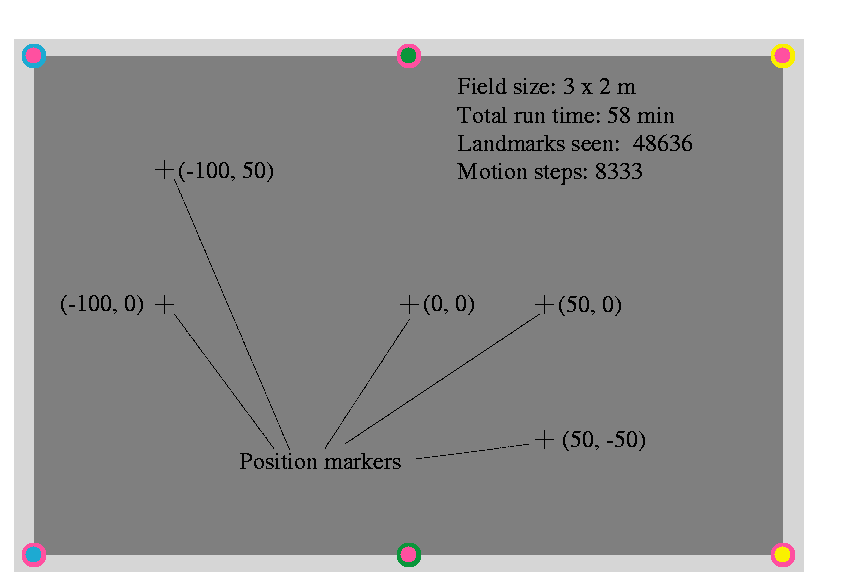

Steffen Gutmann collected this dataset. He directed an Aibo over the field with a joy-stick, and recorded the odometry updates and the observations of the landmarks of the Aibo. The observations are vision based. There is a camera in the head of the Aibo and image processing routine was active to detect objects of the right color in the field of view. The Aibo has a limited field of view, so only 1-2 landmarks are visible at the same time.

# Exercise 1: Localization

Visualize the uncertainty in the localizations from this code (which is an implementation of Table 7.2 from the book. Include estimated position, estimated uncertainty, and actual position. You may use `plot_ellipse` to plot uncertainty ellipses.

In [1]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

ImportError: No module named scipy.stats

In [5]:
def plot_ellipse(ax, loc, cov, color='black'):
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    
    # v[:, j] is the jth eigenvector.
    ell = Ellipse(xy=loc,
                  width=lambda_[0]*2, height=lambda_[1]*2,
                  angle=np.rad2deg(np.arctan2(v[1, 0], v[0, 0])),
                  alpha=.5)
    ell.set_facecolor('none')
    ell.set_edgecolor(color)
    ax.add_artist(ell)

In [6]:
"""
Modified from:
  Extended Kalman Filter
  by Jürgen Sturm, Tijn Schmits, Arnoud Visser
  April 2008 - October 2017

Based on:
Wolfram Burgard's
http://ais.informatik.uni-freiburg.de/teaching/ss18/robotics/slides/11-ekf.pdf
and
http://ais.informatik.uni-freiburg.de/teaching/ss18/robotics/slides/13-slam.pdf

Dataset dlog.dat provided by Steffen Gutmann, 6.5.2004
https://web.archive.org/web/20171024121143/http://cres.usc.edu/radishrepository/view-one.php?name=comparison_of_self-localization_methods_continued
still available via:
https://dspace.mit.edu/handle/1721.1/62255
"""

def parse_line(s):        
    s = s.split(' ')
    if s[0] == 'mark':
        return None, None

    if s[0] == 'obs:':
        x_obs = [float(s[2]) / 100,  # milimeters to decimeters
                 float(s[3]) / 100,
                 float(s[4]) * np.pi / 180] # degrees to radians

        n_obs = int(s[5])
        z_obs = np.zeros((2, n_landmarks))
        for i in range(n_obs):
            idx = 6 + i * 5
            signature, x, y = s[idx+1:idx+4]                
            signature = int(signature[0]), int(signature[2])
            x = float(x) / 100 # milimeters to decimeters
            y = float(y) * np.pi / 180 # degrees to radians

            for landmark in range(n_landmarks):
                if signature[0] == LID[0, landmark] and signature[1] == LID[1, landmark]:
                    z_obs[:, landmark] = [x, y]

        return x_obs, z_obs 
    print(s[0])
    return None, None

def distance(ax, bx, ay, by):
    return np.sqrt((ax - bx)**2 + (ay - by)**2)

def state_transition(x_, P_, ut):
    v = ut[0]  # translation
    da = ut[1] # delta angle
    sa = ut[2] # start angle
    
    # Jacobian with respect to robot location
    G = np.array(
        [[1, 0, -v*np.sin(x_[2]+sa)],
         [0, 1,  v*np.cos(x_[2]+sa)],
         [0, 0,               1]])

    # Jacobian with respect to control
    V = np.array(
        [[np.cos(x_[2]+sa), -v*np.sin(x_[2]+sa)],
         [np.sin(x_[2]+sa),  v*np.cos(x_[2]+sa)],
         [            0,               1]])
    
    # predicted robot position mean
    x_ = np.array(
            [x_[0] + v*np.cos(x_[2]+sa),
             x_[1] + v*np.sin(x_[2]+sa),
             x_[2]+da])

    # predicted covariance
    P_ = G @ P_ @ G.T + V @ M @ V.T;

    return x_, P_

def measurement_update(x_, P_, zt):
    H = np.zeros((2, 3, n_landmarks))
    foundx = np.zeros((dim, n_landmarks ))
    foundP_ = np.zeros((dim, dim, n_landmarks ))
    K = np.zeros((3, 2, n_landmarks))
    for landmark in range(n_landmarks):
        if zt[0, landmark] != 0:   # if Landmark is measured
            # predicted measurement
            z_ = np.array(
                [distance(L[0,landmark], x_[0], L[1,landmark], x_[1]),
                 np.arctan2(L[1,landmark]-x_[1], L[0,landmark]-x_[0]) - x_[2]])

            # Jacobian of H with respect to location
            H[:,:,landmark] = np.array(
                [
                    [-(L[0,landmark]-x_[0])/(L[0, landmark]**2-2*L[0,landmark]*x_[0]+x_[0]**2+L[1,landmark]**2-2*L[1,landmark]*x_[1]+x_[1]**2)**(1/2),
                     -(L[1,landmark]-x_[1])/(L[0, landmark]**2-2*L[0,landmark]*x_[0]+x_[0]**2+L[1,landmark]**2-2*L[1,landmark]*x_[1]+x_[1]**2)**(1/2),
                     0],
                    
                    [(L[1,landmark]-x_[1])/(L[0,landmark]**2-2*L[0,landmark]*x_[0]+x_[0]**2+L[1,landmark]**2-2*L[1,landmark]*x_[1]+x_[1]**2),
                     -(L[0,landmark]-x_[0])/(L[0,landmark]**2-2*L[0,landmark]*x_[0]+x_[0]**2+L[1,landmark]**2-2*L[1,landmark]*x_[1]+x_[1]**2),
                     -1]
                ])

            # predicted  measurement covariance
            S = H[:, :,landmark] @ P_ @ H[:,:,landmark].T + Q;
            
            #Kalman gain
            K[:,:,landmark] = P_ @ H[:,:,landmark].T @ np.linalg.inv(S);

            #innovation
            nu = zt[:,landmark] - z_;
            
            # validation gate
            ro = nu.T @ np.linalg.inv(S) @ nu; # From Kristensen IROS'03, section III.A
            
            if ro < 2:
                # updated mean and covariance
                foundx[:,landmark] = x_ + K[:, :, landmark] @ nu
                foundP_[:,:,landmark] = (np.eye(dim)-K[:, :, landmark] @ H[:,:,landmark]) @ P_
            else:
                # propagate known mean and covariance
                foundx[:,landmark] = x_
                foundP_[:,:,landmark] = P_
                #z[:,t,landmark]=[0, 0]

        else:
            # propagate known mean and covariance
            foundx[:, landmark] = x_;
            foundP_[:, :, landmark] = P_;

    #  determine mean
    x_ = np.mean(foundx, 1)
    P_ = np.mean(foundP_, 2)
    
    return x_, P_

In [7]:
# N is number of observations in dlog.dat

dim = 3
# logfilename = 'data/dlog_firstmark.dat'; N = 758;
# logfilename = 'data/dlog_thirdmark.dat'; N = 1434;
# logfilename = 'data/dlog_fifthmark.dat'; N = 2002;
# logfilename = 'data/dlog_seventhmark.dat'; N = 2803;
logfilename = 'data/dlog.dat'; N = 51666;


# expected user input noise
u_err = .15;
M = u_err*np.eye(2); 

# expected robot location noise
m_err = .1;
Q = m_err*np.eye(2); 

#------------------------------------------------------------ data creation
#
# true robot position at t = 1
xt = np.zeros((dim, N)) # x[:, i] = [x y angle]

# user input at t = 1
u = np.zeros((3, N))              # u = [trans, delta_angle, start_angle]

# Landmark locations
L2006 = np.array([[20,  20, -20, -20],
                  [20, -20,  20, -20]])

# You also need the following information about the landmark positions: 
# cyan:magenta -1500 -1000 magenta:cyan -1500 1000 magenta:green 0 -1000 green:magenta 0 1000 yellow:magenta 1500 -1000 magenta:yellow 1500 1000 
# 0 -> green 
#1 -> magenta 
#2 -> yellow 
#3 -> blue
L = np.array([[-15, -15,   0,  0,  15, 15],
              [-10,  10, -10, 10, -10, 10]])
LID = np.array([[3, 1, 1, 0, 2, 1], 
                [1, 3, 0, 1, 1, 2]])

z = np.zeros((2, N, L.shape[1]))
n_landmarks = 6

mark_t = []

with open(logfilename, 'r') as f:
    lines = f.read().split('\n')
    for t, line in enumerate(lines):
        x_obs, z_obs = parse_line(line)

        if x_obs is None:
            if t > 1 and t < N:
                mark_t += [t]
                xt[:,t] = xt[:,t-1] # skip the observation with a mark, use previous measurement
                z[:,t] = z[:,t-1]
            continue
            
        xt[:, t] = x_obs
        z[:, t] = z_obs

        if t > 0:
            dx=xt[0,t]-xt[0,t-1]
            dy=xt[1,t]-xt[1,t-1]

            u[2,t] = np.arctan2(dy,dx) - xt[2,t-1] # start_angle
            u[2,t] = np.mod(u[2,t] + np.pi, 2*np.pi) - np.pi
            u[1,t] = xt[2,t]-xt[2,t-1]; # diff_angle
            u[1,t] = np.mod(u[1,t] + np.pi, 2*np.pi) - np.pi # FIX angle difference range
            u[0,t] = np.sqrt(dx*dx+dy*dy) # translation


#---------------------------------------------------------------- a prioris
x_ = xt[:, 1] # a priori x = true robot position
P_ = 0*np.eye(3) # a priori P = very certain (no error)

#----------------------------------------------------------------------- EKF
x = np.zeros( (dim, N) );
P = np.zeros( (dim, dim, N) );

for t in range(N):
    #----------------------------------------------------------- prediction
    x_, P_ = state_transition(x_, P_, u[:, t])
    #----------------------------------------------------------- correction
    x_, P_ = measurement_update(x_, P_, z[:, t, :])

    #  create history
    x[:,t] = x_;
    P[:,:,t] = P_;
    
x1 = x
P1 = P
mark_t = np.array(mark_t)

**(a)** Visualize the uncertainty in the localizations from this code (which is an implementation of Table 7.2 from the book). Assume a noise of $15\%$ on range measurements and $10^\circ$ on the bearing measurement.


To set the noise as we want, one way to achieve is to use different $Q_t$ at different time t. Another way is to take the average of measurement of range, and set appropriate varience which cause the mean error locate around 15% with fixed Q. In the following cell, we take 10000000 samples, and check the mean error is what we want.

In [117]:
# Manually set appropriate matrix Q for noise of 15% on range
Q[0,0] = 0.1927
print("Noise on range:", str(np.mean(np.abs(np.sqrt(Q[0,0]) * np.random.randn(10000000)) / np.mean(z[0,:,:]))), "%")

# Manually set appropriate matrix Q for noise of 10 deg
# 10 deg
Q[1,1] = 0.0479
print("Noise on bearing measurement:", np.mean(np.abs(np.sqrt(Q[1,1]) * np.random.randn(10000000))) * 180 / np.pi, "degree")

Noise on range: 0.15011765238731758 %
Noise on bearing measurement: 10.00599851756653 degree


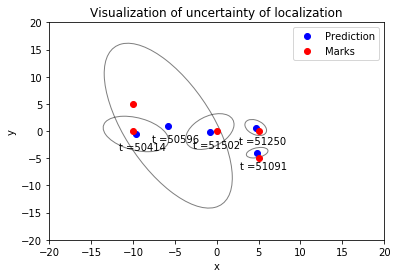

MSE: 7.28954698562765


In [107]:
def mse(x, target):    
    return np.sum((target - x)**2) / target.shape[1]

#target = np.array([[5,5,0,-10,-10],[-5,0,0,0,5]])
target = np.array([[-10,-10,5,5,0],[0,5,-5,0,0]])

fig, ax = plt.subplots()
mark_idx = np.array(mark_t[-5:])

ax.plot(x1[0,mark_idx], x1[1, mark_idx], 'bo', label="Prediction");
ax.plot(target[0,:], target[1,:], 'ro', label="Marks");
for idx in mark_idx:
    plot_ellipse(ax, x1[0:2,idx], P1[0:2, 0:2, idx]);
    ax.annotate('t ={:d}'.format(idx), xy=(x1[0,idx], x1[1,idx]), xytext=(x1[0,idx] - 2, x1[1,idx] - 3))
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Visualization of uncertainty of localization")
plt.legend()
plt.show()

best_mse = mse(x1[0:2,mark_idx], target)
print("MSE:",best_mse)

In this visualization, we select those points t equals 1 tick before the last five mark labels to be visualized, and the ecllipses shows the uncertainty with relative to prediction points. The position of marks should be consider as ground truth to be compared the difference with the position of prediction. The red points label the position of marks. The blue points are the prediction. As you can see, the blue points are close to the red points. It shows that the algorithm works well. We also tested the points t equals 1 tick after the mark labels, and they almost overlap with those points t equals 1 tick before the mark label. So selected points are good enough to be considered as the points should close to the position of marks. The mean square error is 7.2895 with relative to mark positions(ground truth)

**(b)** See if you can find better error parameters for $a_i$ an odometry model to improve the localization

In [108]:
# expected user input noise

dim = 3

best_alpha_1 = 0.0
best_alpha_2 = 0.0

print("Grid search start...")            
print("----------------------------------------------")

for alpha_1 in np.arange(0.10,0.20,0.01):
    for alpha_2 in np.arange(0.10,0.80,0.1):        
        
        #---------------------------------------------------------------- a prioris
        x_ = xt[:, 1] # a priori x = true robot position
        P_ = 0*np.eye(3) # a priori P = very certain (no error)

        #----------------------------------------------------------------------- EKF
        x = np.zeros( (dim, N) );
        P = np.zeros( (dim, dim, N) );
                
        M = np.array([[alpha_1, 0.0],[0.0, alpha_2]])        
        
        for t in range(N):
            #----------------------------------------------------------- prediction
            x_, P_ = state_transition(x_, P_, u[:, t])
            #----------------------------------------------------------- correction            
            x_, P_ = measurement_update(x_, P_, z[:, t, :])

            #  create history
            x[:,t] = x_;
            P[:,:,t] = P_;
            
        mse_one = mse(x[0:2,mark_idx], target)        
        if mse_one < best_mse:
            best_mse = mse_one
            best_alpha_1 = alpha_1
            best_alpha_2 = alpha_2
            best_x = x.copy()
            best_P = P.copy()
            print("New parameters found!")
            print("best_alpha_1:", best_alpha_1)
            print("best_alpha_2:", best_alpha_2)
            print("best_mse:", best_mse)
            print("----------------------------------------------")        

print("Grid search finished!")            
print("best_alpha_1:", best_alpha_1)
print("best_alpha_2:", best_alpha_2)
print("best_mse:", best_mse)

Grid search start...
----------------------------------------------
New parameters found!
best_alpha_1: 0.1
best_alpha_2: 0.1
best_mse: 0.7312474071461564
----------------------------------------------
New parameters found!
best_alpha_1: 0.11
best_alpha_2: 0.1
best_mse: 0.7278253545630904
----------------------------------------------
Grid search finished!
best_alpha_1: 0.11
best_alpha_2: 0.1
best_mse: 0.7278253545630904


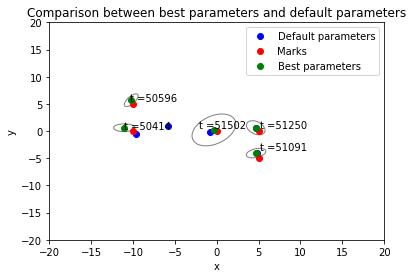

Default alpha 1: 0.15
Default alpha 2: 0.15
best alpha_1: 0.11
best alpha_2: 0.1
best mse: 0.7278253545630904


In [112]:
fig, ax = plt.subplots()

ax.plot(x1[0,mark_idx], x1[1, mark_idx], 'bo', label="Default parameters");
ax.plot(target[0,:], target[1,:], 'ro', label="Marks");
ax.plot(best_x[0,mark_idx], best_x[1, mark_idx], 'go', label="Best parameters");

for idx in mark_idx:
    #plot_ellipse(ax, x1[0:2,idx], P1[0:2, 0:2, idx]);   
    plot_ellipse(ax, best_x[0:2,idx], best_P[0:2, 0:2, idx]);   
    ax.annotate('t ={:d}'.format(idx), xy=(x[0,idx], x[1,idx]), xytext=(x[0,idx], x[1,idx]))
    
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Comparison between best parameters and default parameters")
plt.legend()
plt.show()

print("Default alpha 1:", 0.15)
print("Default alpha 2:", 0.15)


print("best alpha_1:", best_alpha_1)
print("best alpha_2:", best_alpha_2)
print("best mse:", best_mse)

In this part, we did the grid search to find the best parameters. In the implementation of EKF localizatoin above, the fixed $M$ is used instead of $M_t$. So we follow the implementation, and set our matrix of noise in control space as $M_t = \begin{bmatrix} 
\alpha_1 & 0 \\
0 & \alpha_2
\end{bmatrix}
$. When we set $\alpha_1$ as 0.11 and $\alpha_2$ as 0.1, we can improve our result. The best MSE is 0.728, which has improment from original MSE 7.2895. Also the localization uncertainty is smaller than default parameters

The interesting thing is that we thought setting the error as zero could get the best result but it didn't. We think the reason is because if the uncertainty is too small which can cause the inconsistency result with measurement. So in the step of measurement update could fail to update the belief. 

## Exercise 2: SLAM with unknown locations
Copy and modify the code to implement the algorithm in Table 10.1 of the book. Analyze the performance and suggest possible improvements.

In [113]:
def state_transition_SLAM(x_, P_, ut):
    global dim, M_SLAM, factor_dim    
    
    F = np.zeros((3, dim))
    F[0:3,0:3] = np.eye(3)    
    
    v = ut[0]  # translation
    da = ut[1] # delta angle
    sa = ut[2] # start angle
    
    # Jacobian with respect to robot location
    G = np.identity(F.shape[1]) + F.T @ np.array(
        [[0, 0, -v*np.sin(x_[2]+sa)],
         [0, 0,  v*np.cos(x_[2]+sa)],
         [0, 0,               0]]) @ F

    # Jacobian with respect to control
    V = np.array(
        [[np.cos(x_[2]+sa), -v*np.sin(x_[2]+sa)],
         [np.sin(x_[2]+sa),  v*np.cos(x_[2]+sa)],
         [            0,               1]])
    
    R = V @ M_SLAM @ V.T
        
    x_diff = np.array([v*np.cos(x_[2]+sa),v*np.sin(x_[2]+sa),da])
    x_ = x_ + (F.T @ x_diff.reshape(3,1)).squeeze()            
    
    # predicted covariance
    
    P_ = G @ P_ @ G.T + F.T @ R @ F;

    return x_, P_

def measurement_update_SLAM(x_, P_, zt, z_SLAM):
    H = np.zeros((factor_dim, dim, n_landmarks))    
    foundx = np.zeros((dim, n_landmarks ))
    foundP_ = np.zeros((dim, dim, n_landmarks ))
    K = np.zeros((dim, factor_dim, n_landmarks))
    for landmark in range(n_landmarks):
              
        if zt[0, landmark] != 0:   # if Landmark is observed
            if z_SLAM[0, landmark] == 0:   # if landmark is never seen before:                
                z_SLAM[0, landmark] = x_[0] + (zt[0, landmark]*np.cos(zt[1, landmark] + x_[2]))
                z_SLAM[1, landmark] = x_[1] + (zt[0, landmark]*np.sin(zt[1, landmark] + x_[2]))                            
                x_[3 + landmark * factor_dim] = z_SLAM[0, landmark]
                x_[3 + landmark * factor_dim + 1] = z_SLAM[1, landmark]
                
            # predicted measurement
            
            delta = np.array([x_[3 + landmark * factor_dim] - x_[0], x_[3 + landmark * factor_dim + 1] - x_[1]])
            
            q = delta.dot(delta)
            q_sqrt = np.sqrt(q)
            z_ = np.array([q_sqrt,
                           np.arctan2(delta[1], delta[0]) - x_[2]
                          ])
            F = np.zeros((3 + factor_dim, dim))
            F[0:3, 0:3] = np.eye(3)
            F[3: , 3 + factor_dim*landmark: 3 + factor_dim*landmark + factor_dim] = np.eye(factor_dim)
            
            
            # Jacobian of H with respect to location            
            h = np.array(
                [
                    [-delta[0] * q_sqrt, -delta[1] * q_sqrt, 0, delta[0] * q_sqrt, delta[1] * q_sqrt],
                    
                    [delta[1], -delta[0], -q, -delta[1], delta[0]]
                ]) / q
            
            H[:,:,landmark] = h @ F;                                 
            
            # predicted  measurement covariance
            S = H[:, :,landmark] @ P_ @ H[:,:,landmark].T + Q_SLAM;
            
            #Kalman gain
            K[:,:,landmark] = P_ @ H[:,:,landmark].T @ np.linalg.inv(S);

            #innovation
            nu = zt[:,landmark] - z_;
                        
            # validation gate
            ro = nu.T @ np.linalg.inv(S) @ nu; # From Kristensen IROS'03, section III.A
            
            if ro < 2:
                # updated mean and covariance
                foundx[:,landmark] = x_ + K[:, :, landmark] @ nu
                foundP_[:,:,landmark] = (np.eye(dim)-K[:, :, landmark] @ H[:,:,landmark]) @ P_
            else:
                # propagate known mean and covariance
                foundx[:,landmark] = x_
                foundP_[:,:,landmark] = P_
                #z[:,t,landmark]=[0, 0]

        else:
            # propagate known mean and covariance
            foundx[:, landmark] = x_;
            foundP_[:, :, landmark] = P_;

    #  determine mean
    x_ = np.mean(foundx, 1)
    P_ = np.mean(foundP_, 2)
    
    if (x_[2] >np.pi) or (x_[2]<-np.pi):
        while (x_[2] > np.pi):
            x_[2] = x_[2] - (2*np.pi);

        while (x_[2] < -np.pi):
            x_[2] = x_[2] + (2*np.pi);
    
    return x_, P_

In [133]:
factor_dim = 2

x_ = xt[:, 1] # a priori x = true robot position
x_ = np.append(x_, np.zeros((n_landmarks * factor_dim, 1)));
P_ = 0*np.eye(3 + (factor_dim * n_landmarks))
P_[3:, 3:] = 100000*np.eye((factor_dim * n_landmarks))

dim = 3 + (factor_dim * n_landmarks)
#----------------------------------------------------------------------- EKF
x = np.zeros( (dim, N) );
P = np.zeros( (dim, dim, N) );
z_SLAM = np.zeros((factor_dim, n_landmarks))

#M = u_err*np.eye(2); 
M = np.array([[best_alpha_1, 0.0], [0.0, best_alpha_2]])
M_SLAM = M

#Q = m_err*np.eye(2); 
Q_SLAM = Q

for t in range(N):    
    #----------------------------------------------------------- prediction    
    x_, P_ = state_transition_SLAM(x_, P_, u[:, t])
    
    #----------------------------------------------------------- correction
    x_, P_ = measurement_update_SLAM(x_, P_, z[:, t, :], z_SLAM)
    
    #  create history
    x[:,t] = x_;
    P[:,:,t] = P_;
    
x_SLAM = x.copy()
P_SLAM = P.copy()

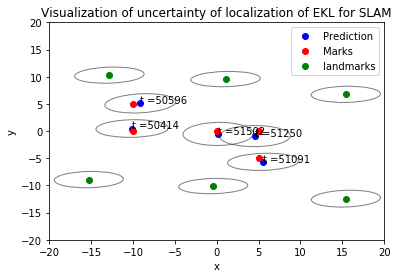

MSE of robot positions: 0.6201428135564211
MSE of landmark positions: 4.057833201728092


In [135]:
fig, ax = plt.subplots()

ax.plot(x_SLAM[0,mark_idx], x_SLAM[1, mark_idx], 'bo', label="Prediction");       
ax.plot(target[0,:], target[1,:], 'ro', label="Marks");
landmark_idx = []
for i in range(n_landmarks):
    landmark_idx += [3+i*2]
    
landmark_idx = np.array(landmark_idx)
    
ax.plot(x_SLAM[landmark_idx, -1], x_SLAM[landmark_idx + 1, -1], 'go', label="landmarks");

for idx in mark_idx:
    plot_ellipse(ax, x_SLAM[0:2,idx], P_SLAM[0:2, 0:2, idx]); 
    
    ax.annotate('t ={:d}'.format(idx), xy=(x_SLAM[0,idx], x_SLAM[1,idx]), xytext=(x_SLAM[0,idx], x_SLAM[1,idx]))
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Visualization of uncertainty of localization of EKL for SLAM")
plt.legend()

x_idx = range(3,3 + 2 * n_landmarks, 2)
y_idx = range(4,4 + 2 * n_landmarks, 2)

for idx in x_idx:
    plot_ellipse(ax, x_SLAM[idx:idx+factor_dim,-1], P_SLAM[idx:idx+factor_dim, idx:idx+factor_dim, -1]); 

plt.show()

mse_value = mse(x_SLAM[0:2,mark_idx], target)
print("MSE of robot positions:",mse_value)


mse_value_2 = mse(np.array([x_SLAM[x_idx,-1], x_SLAM[y_idx,-1]]), L)
print("MSE of landmark positions:",mse_value_2)

In this part, the algorithm not only needs to predict the robot's state, but also the position of the landmarks.When the robot senses landmarks several times, the uncertainty of landmarks will decrease, so will the uncertainty of its current pose. Thus, we can collect more observations of landmarks to improve the performance. 


Also, we normalize the robot's angle, $\theta$, which could be out of the reasonable range when doing measurement updating, between $-\pi$ and $\pi$. The nomalization of angle improve the result a lot, MSE of robot positions is even better than previous part. Furthermore, tuning covariances of motion noise($\alpha$) is also significant to have better performance.

One of the problem is the initialization of covariance matrix. In theory, covariance matrix should be initialized as: $\begin{bmatrix} 
0 & 0 & 0 & 0 & \cdots & 0\\
0 & 0 & 0 & 0 & \cdots & 0\\
0 & 0 & 0 & 0 & \cdots & 0\\
0 & 0 & 0 & \infty & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots\\
0 & 0 & 0 & 0 & \cdots & \infty\\
\end{bmatrix}$

In our textbook page 329, it mentions if we set infinity of covariance matrix as very large value, which may induce numerical instabilities. In our implementation, we can only set infinity as 100000, otherwise the uncertainty could be very huge.

Other possible computational performance improvement might be about faster computation of sparse matrix mutiplication. There are some existed method, for example "YUSTER, Raphael; ZWICK, Uri. Fast sparse matrix multiplication", which can finish two n x n matrice multiplication with m non-zero elements in $O(m^{0.7}n^{1.2} + n^{2+o(1)})$. In EKF_SLAM, matrix F is sparse, which can bring on a lot of square sparse matrice.